### Rise

In [188]:
from model import *
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

In [199]:
model = Net()
model.load_state_dict(torch.load("model.pkt"))
model.eval()

Net(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=63, bias=True)
  (fc4): Linear(in_features=63, out_features=10, bias=True)
)

In [200]:
from mnist import train_ds
from mask import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
for (x,y) in train_loader:
    print(y)
    print(torch.argmax(model(x), dim=1))
    break

tensor([2, 3, 8, 5, 9, 9, 8, 5, 9, 5, 2, 2, 8, 4, 1, 3, 0, 3, 0, 3, 3, 2, 1, 5,
        5, 0, 9, 4, 8, 0, 8, 1])
tensor([2, 3, 8, 5, 9, 9, 8, 5, 9, 5, 2, 2, 8, 6, 1, 3, 0, 3, 0, 3, 3, 7, 1, 5,
        5, 0, 9, 4, 8, 0, 8, 1])


(-0.5, 27.5, 27.5, -0.5)

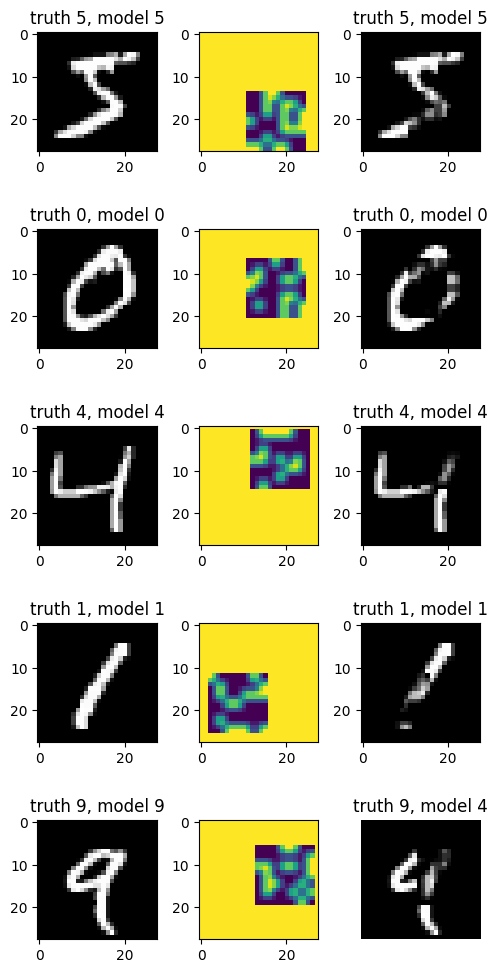

In [270]:
f, axarr = plt.subplots(5, 3, figsize=(5,10))

for i in range(5):
    X, y = train_ds[i]
    mask = binary_masks(10, 28, 28, p=.3, divide_size=4)

    y_pred = torch.argmax(model(X.reshape((1, ) + X.shape)), dim=1).item()
    y_pred_mask = torch.argmax(model((X * mask[0]).reshape((1, ) + X.shape)), dim=1).item()

    axarr[i][0].imshow(X[0], cmap='gray')
    axarr[i][0].set_title(f"truth {str(y)}, model {y_pred}")
    axarr[i][1].imshow(mask[0][0] * 255)

    axarr[i][2].set_title(f"truth {str(y)}, model {y_pred_mask}")
    axarr[i][2].imshow(mask[0][0] * X[0], cmap='gray')
plt.tight_layout()
plt.axis('off')

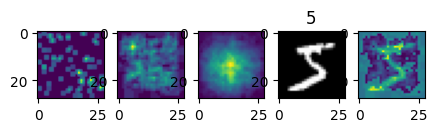

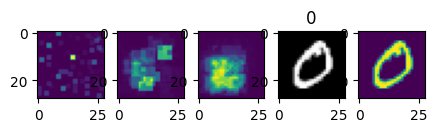

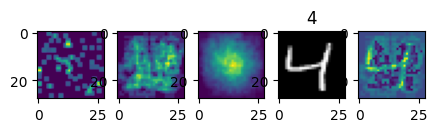

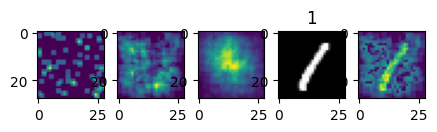

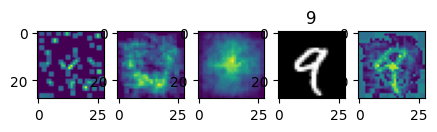

In [285]:
from PIL import Image

example_image, example_class_id = train_ds[2]

for i in range(5):
    x, y = train_ds[i]
    f, axarr = plt.subplots(1, 5, figsize=(5,10))
    img_mask_score_big = mask_score(model, x[0], class_id=class_id, divide_size=16)
    img_mask_score_medium = mask_score(model, x[0], class_id=class_id, divide_size=8)
    img_mask_score_small = mask_score(model, x[0], class_id=class_id, divide_size=4)

    heatmap = img_mask_score_medium
    img, h_img = TF.to_pil_image(x), TF.to_pil_image(heatmap)
    res = Image.blend(img, h_img, 0.5)
#    plt.imshow(res)

    axarr[0].imshow(img_mask_score_big.detach().numpy())
    axarr[1].imshow(img_mask_score_medium.detach().numpy())
    axarr[2].imshow(img_mask_score_small.detach().numpy())
    axarr[3].set_title(y)
    axarr[3].imshow(x[0], cmap='gray')
    axarr[4].imshow(res)

# Metric - deletion

In [266]:
from metrics import deletion

In [267]:
def f(x):
    out = F.softmax(model(x.reshape((1, 1) + x.shape)), dim=1)[0]
    return out[example_class_id].detach().numpy()
    
x, y = deletion(
    f=f,
    image=example_image[0],
    s=img_mask_score,
    N=1
)

from optimization_utils.numeric.trapezoidal import trapezoidal 
def area_under_f():
    score = trapezoidal(lambda x: y[int(x)], 0, len(x), n=len(x))
    return (score)

## How little data does the model need ?

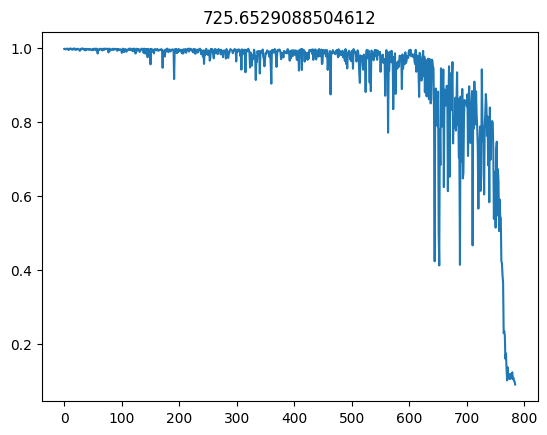

In [268]:
plt.title(area_under_f())
plt.plot(x, y)

# Metric - insertion

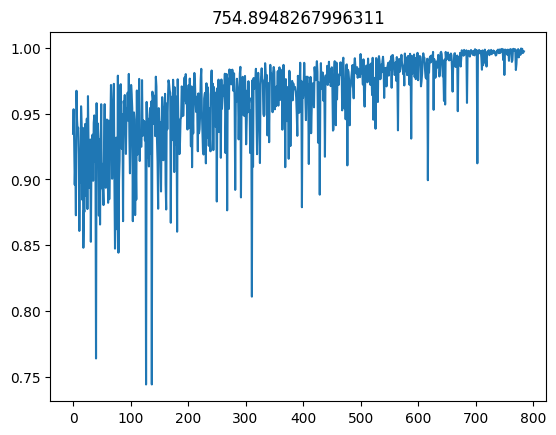

In [269]:
from metrics import insertion

def f(x):
    out = F.softmax(model(x.reshape((1, 1) + x.shape)), dim=1)[0]
    return out[example_class_id].detach().numpy()
    
x, y = insertion(
    f=f,
    image=example_image[0],
    s=img_mask_score,
    N=1
)

from optimization_utils.numeric.trapezoidal import trapezoidal 
def area_under_f():
    score = trapezoidal(lambda x: y[int(x)], 0, len(x), n=len(x))
    return (score)

plt.title(area_under_f())
plt.plot(x, y)